In [2]:
#pip install vaderSentiment

# PROJECT NAME

### PROJECT MEMBERS

In [3]:
#Research Question and Background
#Hypothesis

# Overall question
- Does emotion(postive/negative) influence reaction time
    - fear
- Does isolation affect emotion
- Emotion and memory
    - Happy, sad, fear, sentimental, bored, depression
    - Does music help
    - Does being happy/sad/mad help
    - Enviornment 
        - Loction of learning, learning at school Environment help retain knowledge 
            -Does the emotion in that environment affect it
        - How well can people adapt to forced learning measures
        - 
     - Does body posture affect memory
     - Do drugs imporve memory
         - Does time of consumtion matter
     - 
             
    
- Emotion and music

# Emotions that we want to look at:
- FEAR
- ANGER
- SADNESS
- SENTIMENTAL

# Regions in the brain we want to look at:
- Amygdala
- Temporal lobe
- Prefrontal Cortex
- Hippocampus


# I. Set Up

In [4]:
from lisc import Counts
from lisc.utils.db import SCDB
from lisc.plts.counts import *
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Data Import
hippDf = pd.read_csv('hippoCorpusV2.csv')
islandersDf = pd.read_csv('Islander_data.csv')

### 1a. Text Mining

In [5]:
#First term list we are searching for
terms_a = [['"fear"'], ['"anger"'], ['"sadness"'], ['"sentimental"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts = Counts()
counts.add_terms(terms_a)

# Collect data using the run_collection method
counts.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts.check_counts()

Running counts for:  "fear"
Running counts for:  "anger"
Running counts for:  "sadness"
Running counts for:  "sentimental"
The number of documents found for each search term is:
  '"fear"'          -   76043
  '"anger"'         -   16769
  '"sadness"'       -    6468
  '"sentimental"'   -     236


In [6]:
counts.counts

array([[   0, 2975, 1956,   11],
       [2975,    0, 2420,    4],
       [1956, 2420,    0,    2],
       [  11,    4,    2,    0]])

In [7]:
#Second term list we are searching for
terms_b = [['"amygdala"'], ['"temporal lobe"'], ['"prefrontal cortex"'], ['"hippocampus"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts2 = Counts()
counts2.add_terms(terms_b)

# Collect data using the run_collection method
counts2.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts2.check_counts()

Running counts for:  "amygdala"
Running counts for:  "temporal lobe"
Running counts for:  "prefrontal cortex"
Running counts for:  "hippocampus"
The number of documents found for each search term is:
  '"amygdala"'            -    38276
  '"temporal lobe"'       -    34551
  '"prefrontal cortex"'   -    52540
  '"hippocampus"'         -   119606


In [8]:
counts2.counts

array([[    0,  2287,  6597, 11841],
       [ 2287,     0,  1659,  6508],
       [ 6597,  1659,     0,  8857],
       [11841,  6508,  8857,     0]])

In [9]:
#Third term list we are searching for
terms_c = [['"amygdala"'], ['"hippocampus"'],['"fear"'], ['"anger"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts3 = Counts()
counts3.add_terms(terms_c)

# Collect data using the run_collection method
counts3.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts3.check_counts()

Running counts for:  "amygdala"
Running counts for:  "hippocampus"
Running counts for:  "fear"
Running counts for:  "anger"
The number of documents found for each search term is:
  '"amygdala"'      -    38276
  '"hippocampus"'   -   119606
  '"fear"'          -    76043
  '"anger"'         -    16769


In [10]:
#Fourth term list we are searching for
terms_d = [['"amygdala"'], ['"prefrontal cortex"'],['"fear"'], ['"attention"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts4 = Counts()
counts4.add_terms(terms_d)

# Collect data using the run_collection method
counts4.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts4.check_counts()

Running counts for:  "amygdala"
Running counts for:  "prefrontal cortex"
Running counts for:  "fear"
Running counts for:  "attention"
The number of documents found for each search term is:
  '"amygdala"'            -    38276
  '"prefrontal cortex"'   -    52540
  '"fear"'                -    76043
  '"attention"'           -   478879


In [11]:
counts4.counts

array([[   0, 6597, 5170, 1679],
       [6597,    0, 2099, 5085],
       [5170, 2099,    0, 3861],
       [1679, 5085, 3861,    0]])

# II. Data Cleaning


Going to focus on these columns and check for null values:
- annotatorAge: Lower limit of the age bucket of the worker.
  Buckets are: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54,55+
  
- story: Story about the imagined or recalled event (15-25     sentences)
- distracted: How distracted were you while writing your story? (5-point Likert)

- draining: How taxing/draining was writing for you emotionally? (5-point Likert)

- frequency: How often do you think about or talk about this event? (5-point Likert)

- importance: How impactful, important, or personal is this story/event to you? (5-point Likert)

- logTimeSinceEvent: Log of time (days) since the recalled event happened

- mainEvent: Short phrase describing the main event described

- similarity: How similar to your life does this event/story feel to you? (5-point Likert)

- stressful: How stressful was this writing task? (5-point Likert)

- summary: Summary of the events in the story (1-3 sentences)

- timeSinceEvent: Time (number of days) since the recalled event happened

In [12]:
#Check for null values, if null value found returns True
print('AnnotatorAge null values ... ',hippDf['annotatorAge'].isnull().values.any())
print('Story null values ...        ',hippDf['story'].isnull().values.any())
print('Distracted null values ...   ', hippDf['distracted'].isnull().values.any())
print('Draining null values ...     ', hippDf['draining'].isnull().values.any())
print('Frequency null values ...    ', hippDf['frequency'].isnull().values.any())
print('Importance null values ...   ', hippDf['importance'].isnull().values.any())
print('LTSinceEvent null values ... ', hippDf['logTimeSinceEvent'].isnull().values.any())
print('Similarity null values ...   ', hippDf['similarity'].isnull().values.any())
print('Stressful null values ...    ', hippDf['stressful'].isnull().values.any())
print('TimeSinceEvent null values ..', hippDf['timeSinceEvent'].isnull().values.any())


AnnotatorAge null values ...  True
Story null values ...         False
Distracted null values ...    False
Draining null values ...      False
Frequency null values ...     True
Importance null values ...    True
LTSinceEvent null values ...  False
Similarity null values ...    True
Stressful null values ...     False
TimeSinceEvent null values .. False


As we can see there are some null values so lets remove all those rows that contain a null value in these columns. However ordinal valued columns are the ones we need to insure have no NaN values. So we will remove rows that contain NaN values from the AnnotatorAge column. Later on we will look into the NaN values for frequency and importance as these varry based on their groups

In [13]:
noNaNHippDf = hippDf.dropna(subset=['annotatorAge'])


In [14]:
noNaNHippDf['annotatorAge'].unique()

array([25., 35., 30., 18., 50., 40., 45., 55.])


From this, we can see that there are 8 unique age variables. For this project, we will classify the age bucket 18 and 25 as 'Youth', 30,35,40 as 'Adults', and 45,50,55 as 'Seniors' into a new column called "AgeGroup"

In [15]:
def ageGroup(row):
    if row['annotatorAge'] == 18 or row['annotatorAge'] == 25:
        return 'Youth'
    elif row['annotatorAge'] == 30 or row['annotatorAge'] == 35 or row['annotatorAge'] == 40:
        return 'Adult'
    elif row['annotatorAge'] == 45 or row['annotatorAge'] == 50 or row['annotatorAge'] == 55:
        return 'Senior'
    else:
        return None

In [16]:
noNaNHippDf['AgeGroup'] = noNaNHippDf.apply(lambda row: ageGroup(row),axis=1)
noNaNHippDf

/var/folders/93/dy9vvt2s2rl2nhwc9km6br000000gn/T/ipykernel_38105/187246375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noNaNHippDf['AgeGroup'] = noNaNHippDf.apply(lambda row: ageGroup(row),axis=1)


,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,...,openness,recAgnPairId,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent,AgeGroup
0,32RIADZISTQWI5XIVG5BN0VMYFRS4U,1641,XI8VK89S,25.0,man,white,1.0,1.0,NaN,3.0,...,0.000,NaN,3018Q3ZVOJCZJFDMPSFXATCQ4DARA2,3.0,"I've been to a couple concerts, but not many.","Concerts are my most favorite thing, and my bo...",1.0,My boyfriend and I went to a concert together ...,90.0,Youth
1,3018Q3ZVOJCZJFDMPSFXATCQ4DARA2,1245,1HN5ZZ1D,25.0,woman,white,1.0,1.0,3.0,4.0,...,1.000,NaN,3018Q3ZVOJCZJFDMPSFXATCQ4DARA2,NaN,NaN,"The day started perfectly, with a great drive ...",1.0,My boyfriend and I went to a concert together ...,90.0,Youth
2,3IRIK4HM3B6UQBC0HI8Q5TBJZLEC61,1159,8SBPL7EI,35.0,woman,black,1.0,1.0,NaN,4.0,...,0.500,NaN,3018Q3ZVOJCZJFDMPSFXATCQG04RAI,3.0,I am a mother myself,It seems just like yesterday but today makes f...,1.0,My sister gave birth to my twin niece and neph...,150.0,Adult
3,3018Q3ZVOJCZJFDMPSFXATCQG04RAI,500,M1QQED2V,30.0,woman,white,1.0,4.0,3.0,5.0,...,1.000,NaN,3018Q3ZVOJCZJFDMPSFXATCQG04RAI,NaN,NaN,"Five months ago, my niece and nephew were born...",2.0,My sister gave birth to my twin niece and neph...,150.0,Adult
4,3MTMREQS4W44RBU8OMP3XSK8NMJAWZ,1074,DU3RPZDB,25.0,man,white,2.0,2.0,NaN,3.0,...,0.250,NaN,3018Q3ZVOJCZJFDMPSFXATCQG06AR3,4.0,Because I also have money problems,About a month ago I went to burning man. I was...,4.0,It is always a journey for me to go to burning...,30.0,Youth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6849,3SKEMFQBZ4RZDN7C2AMMDQKHCV68K1,926,KVSO6L8P,30.0,woman,other,3.0,5.0,3.0,5.0,...,0.125,NaN,NaN,NaN,NaN,My dog was diagnosed with lymphoma a year ago ...,5.0,"My dog, who had lymphoma, was suffering so I h...",150.0,Adult
6850,39PAAFCODNMWRITC4CBO6VRL6O4TV3,3044,QJB7AXPP,18.0,woman,asian,4.0,2.0,4.0,2.0,...,-0.500,NaN,NaN,NaN,NaN,"Over my vacation from my job, I went to Casper...",5.0,"On vacation, a side job was taken to plan an e...",570.0,Youth
6851,3FE2ERCCZYU396R8MJGQ6TWGLSMOPR,1008,IJP8D12L,35.0,man,asian,1.0,2.0,2.0,4.0,...,0.500,NaN,NaN,NaN,NaN,This event was a birthday party for my nephew....,2.0,This was a birthday party for my nephew that h...,21.0,Adult
6852,3J88R45B2HKQ3F50NA3MP6N9XXKPXS,1462,LCKEHYRF,30.0,man,hisp,1.0,1.0,3.0,3.0,...,0.500,NaN,NaN,NaN,NaN,This event occurred about two weeks ago. I was...,2.0,It was my little cousin's birthday and went to...,14.0,Adult


In [17]:
noNaNHippDf['AgeGroup'].unique()

array(['Youth', 'Adult', 'Senior'], dtype=object)

In [20]:
#Categorizes annotatorAge into different age groups
noNaNHippDf.loc[(noNaNHippDf['annotatorAge'] <= 18),  'AgeGroup'] = "Youth"
noNaNHippDf.loc[(noNaNHippDf['annotatorAge'] <= 18),  'AgeGroup'] = "Youth"
noNaNHippDf.loc[(noNaNHippDf['annotatorAge'] >= 50),  'AgeGroup'] = "Senior"
noNaNHippDf['AgeGroup'].fillna("Adult", inplace=True)

#Move the AgeGroup column
noNaNHippDf = noNaNHippDf[['AgeGroup','annotatorAge','story']]

#View dataframe
noNaNHippDf

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,AgeGroup,annotatorAge,story
0,Youth,25.0,"Concerts are my most favorite thing, and my bo..."
1,Youth,25.0,"The day started perfectly, with a great drive ..."
2,Adult,35.0,It seems just like yesterday but today makes f...
3,Adult,30.0,"Five months ago, my niece and nephew were born..."
4,Youth,25.0,About a month ago I went to burning man. I was...
...,...,...,...
6849,Adult,30.0,My dog was diagnosed with lymphoma a year ago ...
6850,Youth,18.0,"Over my vacation from my job, I went to Casper..."
6851,Adult,35.0,This event was a birthday party for my nephew....
6852,Adult,30.0,This event occurred about two weeks ago. I was...


In [22]:
recalled_df = hippDf[hippDf['memType']=="recalled"]
imagined_df = hippDf[hippDf['memType']=="imagined"]
retold_df = hippDf[hippDf['memType']=="retold"]


Going to focus on these columns:
- annotatorAge: Lower limit of the age bucket of the worker.
  Buckets are: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54,55+
  
- story: Story about the imagined or recalled event (15-25     sentences)
- distracted: How distracted were you while writing your story? (5-point Likert)

- draining: How taxing/draining was writing for you emotionally? (5-point Likert)

- frequency: How often do you think about or talk about this event? (5-point Likert)

- importance: How impactful, important, or personal is this story/event to you? (5-point Likert)

- logTimeSinceEvent: Log of time (days) since the recalled event happened

- mainEvent: Short phrase describing the main event described

- similarity: How similar to your life does this event/story feel to you? (5-point Likert)

- stressful: How stressful was this writing task? (5-point Likert)

- summary: Summary of the events in the story (1-3 sentences)

- timeSinceEvent: Time (number of days) since the recalled event happened



## Splitting data by group
Splitting the data with the memType column with "recalled","imagined", and "retold"

In [23]:
newRecalled = recalled_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent']]
newImagined = imagined_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent']]
newRetold = retold_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent']]

In [24]:
# Selected annotatorAge and story columns
new_df = hippDf[['annotatorAge','story']]
new_df

,annotatorAge,story
0,25.0,"Concerts are my most favorite thing, and my bo..."
1,25.0,"The day started perfectly, with a great drive ..."
2,35.0,It seems just like yesterday but today makes f...
3,30.0,"Five months ago, my niece and nephew were born..."
4,25.0,About a month ago I went to burning man. I was...
...,...,...
6849,30.0,My dog was diagnosed with lymphoma a year ago ...
6850,18.0,"Over my vacation from my job, I went to Casper..."
6851,35.0,This event was a birthday party for my nephew....
6852,30.0,This event occurred about two weeks ago. I was...


In [25]:
#Show unique values of age
hippDf['annotatorAge'].unique()

array([25., 35., 30., 18., 50., 40., 45., 55., nan])

From this, we can see that there are 8 unique age variables. For this project, we will classify the ages 0-18 as 'Youth', 19-49 as 'Adults', and 50+ as 'Seniors' into a new column called "AgeGroup"

In [26]:
#Categorizes annotatorAge into different age groups
new_df.loc[(new_df['annotatorAge'] <= 18),  'AgeGroup'] = "Youth"
new_df.loc[(new_df['annotatorAge'] <= 18),  'AgeGroup'] = "Youth"
new_df.loc[(new_df['annotatorAge'] >= 50),  'AgeGroup'] = "Senior"
new_df['AgeGroup'].fillna("Adult", inplace=True)

#Move the AgeGroup column
new_df = new_df[['AgeGroup','annotatorAge','story']]

#View dataframe
new_df

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCo

,AgeGroup,annotatorAge,story
0,Adult,25.0,"Concerts are my most favorite thing, and my bo..."
1,Adult,25.0,"The day started perfectly, with a great drive ..."
2,Adult,35.0,It seems just like yesterday but today makes f...
3,Adult,30.0,"Five months ago, my niece and nephew were born..."
4,Adult,25.0,About a month ago I went to burning man. I was...
...,...,...,...
6849,Adult,30.0,My dog was diagnosed with lymphoma a year ago ...
6850,Youth,18.0,"Over my vacation from my job, I went to Casper..."
6851,Adult,35.0,This event was a birthday party for my nephew....
6852,Adult,30.0,This event occurred about two weeks ago. I was...


In [27]:
#Drop all null values
new_df.dropna(inplace=True)
new_df.reset_index(drop=True, inplace=True)
print(new_df['story'].isna().sum())
print(new_df['annotatorAge'].isna().sum())
print(new_df['AgeGroup'].isna().sum())


0
0
0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Dropped all null values in case it could affect our analysis

# III. Exploratory Data Analysis

### IIIa. Sentiment Analysis

In [28]:
# Sentiment Analysis
sentiment_score = []
sentiment = []
sentiment_obj = SentimentIntensityAnalyzer()
for i in range(len(new_df['story'])):
    sentiment_score.append(sentiment_obj.polarity_scores(new_df['story'][i]))
    score = sentiment_obj.polarity_scores(new_df['story'][i])['compound']
    if score > 0.05:
        sentiment.append("Positive")
    elif score <= -0.05:
        sentiment.append("Negative")
    else:
        sentiment.append("Neutral")
    

In [31]:
#Add 2 new columns to the dataframe
new_df['sentiment_score'] = sentiment_score
new_df['sentiment'] = sentiment

#View dataset
new_df.head()

/var/folders/93/dy9vvt2s2rl2nhwc9km6br000000gn/T/ipykernel_38105/597929542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['sentiment_score'] = sentiment_score
/var/folders/93/dy9vvt2s2rl2nhwc9km6br000000gn/T/ipykernel_38105/597929542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['sentiment'] = sentiment


,AgeGroup,annotatorAge,story,sentiment_score,sentiment
0,Adult,25.0,"Concerts are my most favorite thing, and my bo...","{'neg': 0.011, 'neu': 0.714, 'pos': 0.274, 'co...",Positive
1,Adult,25.0,"The day started perfectly, with a great drive ...","{'neg': 0.03, 'neu': 0.704, 'pos': 0.266, 'com...",Positive
2,Adult,35.0,It seems just like yesterday but today makes f...,"{'neg': 0.023, 'neu': 0.826, 'pos': 0.151, 'co...",Positive
3,Adult,30.0,"Five months ago, my niece and nephew were born...","{'neg': 0.041, 'neu': 0.794, 'pos': 0.165, 'co...",Positive
4,Adult,25.0,About a month ago I went to burning man. I was...,"{'neg': 0.052, 'neu': 0.872, 'pos': 0.076, 'co...",Positive


### IIIb. Visualizations

# Positive: 5418
# Negative: 1384


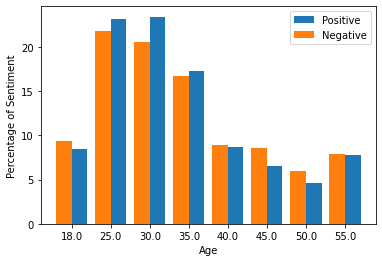

---------- Positive Stats ----------
Age: 18.0 Percentage: 8.43484680693983
Age: 25.0 Percentage: 23.145071982281284
Age: 30.0 Percentage: 23.421926910299003
Age: 35.0 Percentage: 17.33111849390919
Age: 40.0 Percentage: 8.693244739756366
Age: 45.0 Percentage: 6.5891472868217065
Age: 50.0 Percentage: 4.614248800295312
Age: 55.0 Percentage: 7.770394979697305
---------- Negative Stats ----------
Age: 18.0 Percentage: 9.320809248554914
Age: 25.0 Percentage: 21.820809248554912
Age: 30.0 Percentage: 20.592485549132945
Age: 35.0 Percentage: 16.76300578034682
Age: 40.0 Percentage: 8.959537572254336
Age: 45.0 Percentage: 8.598265895953757
Age: 50.0 Percentage: 5.997109826589595
Age: 55.0 Percentage: 7.947976878612717


In [55]:
X = new_df['annotatorAge'].unique()
X.sort()
x_axis = np.arange(len(new_df['annotatorAge'].unique()))


# Calculate Positive Amount and Percentages
positive = []
positive_total = 0
for x in X:
    value = len(new_df[(new_df['annotatorAge'] == x) & (new_df['sentiment'] == 'Positive')])
    positive.append(value)
    positive_total+=value

positive_percentage = []
for x in positive:
    positive_percentage.append((x/positive_total) * 100)


# Calculate Negative Amount and Percentages
negative = []
negative_total = 0
for x in X:
    value = len(new_df[(new_df['annotatorAge'] == x) & (new_df['sentiment'] == 'Negative')])
    negative.append(value)
    negative_total+=value

negative_percentage = []
for x in negative:
    negative_percentage.append((x/negative_total) * 100)

plt.xticks(x_axis, X)
plt.bar(x_axis + 0.2 ,positive_percentage,0.4,label='Positive')
plt.bar(x_axis - 0.2 ,negative_percentage,0.4,label='Negative')
plt.ylabel('Percentage of Sentiment')
plt.xlabel('Age')
plt.legend()
plt.show()

positive_stats = {}
negative_stats = {}
index = 0
for val in X:
    positive_stats[val] = positive_percentage[index]
    negative_stats[val] = negative_percentage[index]
    index+=1
print('---------- Positive Stats ----------')
for i in positive_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(positive_stats[i]))

print('---------- Negative Stats ----------')
for i in negative_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(negative_stats[i]))

From this graph we can see that...

Text(0.5, 1.0, 'Number of Sentiment Observations by Age Group')

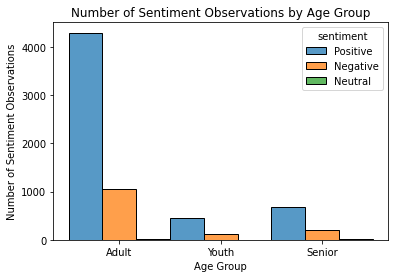

In [ ]:
graph_2 = sns.histplot(x="AgeGroup", hue="sentiment", data=new_df, multiple = "dodge")

graph_2.set(xlabel = 'Age Group', ylabel='Number of Sentiment Observations')
plt.title("Number of Sentiment Observations by Age Group")

Next, we will look at the number of positive, negative, and neutral sentiments between different age groups. We can see that both positive and negative sentiments follow the same trend: Adults with the most observations, followed by Senior, and finally Youth. 

# IV. Conclusion and Discussion

In [ ]:
#Conclusion